In [2]:
# standard python tools
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread

In [1]:
# make sure pyqae is available
import pyqae as pq
    
# check to see if it is running on pyspark
try:
    import pyspark
except ImportError:
    print('Using a fake spark backend for processing')
    import pyqae.simplespark as pyspark
    sc = pyspark.LocalSparkContext()

from pyqae.images import viz
# multidimensional distributed arrays
from pyqae.nd import filt_tensor, tensor_from_rdd, save_tensor_local, tensor_to_dataframe, save_tensor_parquet

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'bone'  # change default colormap see plt.cm for other colormap options

In [4]:
pc = pq.PyqaeContext(sc)

# Read in Images
Here the images are read from a directory using a wildcard path. Since the path is local, we can use the ```pc.readImageDirectoryLocal``` instead of the ```pc.readImageDirectory``` method since it is faster

In [5]:
img_rdd = pc.readImageDirectoryLocal("/Volumes/ExDisk/train_sm/*.jpeg")

/Volumes/ExDisk/train_sm/set107_1.jpeg


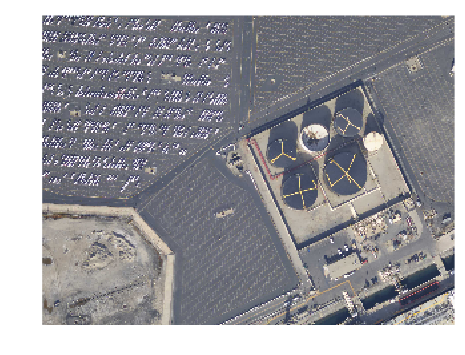

In [6]:
%matplotlib inline
filename, imgdata = img_rdd.mapValues(lambda x: x[::10, ::10]).first() # downsample first
print(filename)
_ = viz.show_image(imgdata)

In [7]:
dist_brain_img = tensor_from_rdd(img_rdd)
print(dist_brain_img, dist_brain_img.shape)

BoltArray
mode: spark
shape: (350, 2329, 3099, 3)
 (350, 2329, 3099, 3)


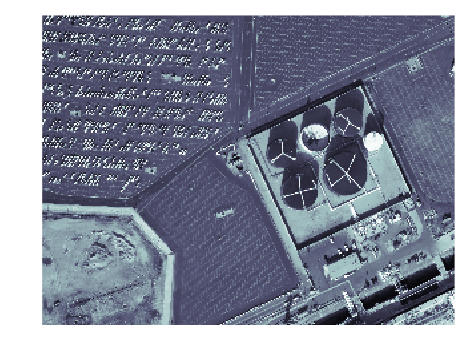

In [8]:
%matplotlib inline
_ = viz.show_image(dist_brain_img[0,::10, ::10, 0].toarray())

In [12]:
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.exposure import adjust_gamma
from skimage.filters import gaussian, median, rank
from skimage.morphology import disk

def rolling_ball_background(in_image, radius):
    bg_image = rank.mean(in_image, disk(radius))
    out_image = img_as_float(in_image) - img_as_float(bg_image)
    return out_image
    
def gamma_bg_sub(img, radius = 10, gamma = 0.05):
    """
    Perform gamma correction and then a simple rolling background subtraction
    :param img: the image to process (2D)
    :param radius: the radius of the ball
    :param gamma: the factor for the gamma
    :return: image of the same dimensions with the correction
    """
    img = adjust_gamma(img, gamma)
    img = rolling_ball_background(img, radius)
    return img

In [13]:
dist_filt_img = filt_tensor(dist_brain_img, filter_op = gamma_bg_sub, tile_size=(100, 100), padding = (10, 10))

/Users/mader/anaconda/lib/python3.5/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


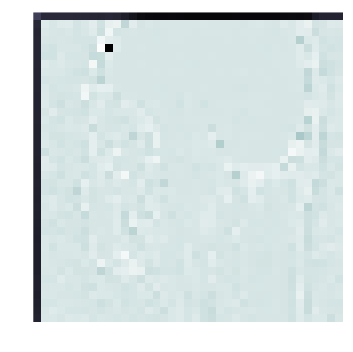

In [14]:
%matplotlib inline
_ = viz.show_image(dist_filt_img[0,::10, ::10, 0].toarray())

# Save the output
The files here are then saved from each worker node in parallel and the filename is returned to the master so we can see the new files that have been created. The RDD has ```cache``` applied to avoid writing the same file multiple times

In [15]:
save_tensor_local(dist_filt_img, '/Users/mader/Downloads/test_dataE')

'/Users/mader/Downloads/test_dataE'

In [18]:
tensor_to_dataframe(dist_filt_img).write.parquet("test_output")

In [19]:
save_tensor_parquet(dist_filt_img, '/Users/mader/Downloads/test_data_pqt')

In [12]:
ch_img = dist_brain_img.chunk(size = (100, 100), padding = (20, 20))

In [22]:
a, b = ch_img.tordd().first()

In [23]:
ch_img._shape, ch_img._split, ch_img._dtype, ch_img._plan, ch_img._padding, ch_img._ordered

((350, 2329, 3099, 3),
 1,
 dtype('uint8'),
 array([100, 100,   3]),
 array([20, 20,  0]),
 None)

In [28]:
dist_brain_img[0,0,3099]

ValueError: Index 3099 in dimension 2 with shape 3099 would produce an empty dimension

In [ ]:
Pmg.open('')